# Order ameloblasts by pseudotime   
See https://github.com/AllonKleinLab/PBA and [1] for more details on the "potential" value used to order ameloblasts.


[1] Weinreb C, Wolock S, Tusi BK, Socolovsky M, Klein AM. Fundamental limits on dynamic inference from single-cell snapshots. Proc Natl Acad Sci U S A. 2018 Mar 6;115(10):E2467–76.

In [1]:
import os,sys
import datetime

### Import scanpy

In [2]:
import scanpy.api as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.3.4 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
Memory usage: current 0.17 GB, difference +0.17 GB


### Import my utility functions and import statements from github

In [3]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190425_11h32"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import
import rz_utility_spring as srz

python version: 3.6.7


# Load data and place into an annData object

In [5]:
!ls data_from_geo

cell_info_8594x25.tsv         injury_barcodes.tsv
control_barcodes.tsv          injury_genes.tsv
control_genes.tsv             injury_loom.loom
control_loom.loom             injury_matrix.mtx
control_matrix.mtx            raw_counts_8594x27998.mtx
gene_names_alphabetically.txt


In [6]:
obspath = 'data_from_geo/cell_info_8594x25.tsv'
countpath = 'data_from_geo/raw_counts_8594x27998.mtx'
genepath = 'data_from_geo/gene_names_alphabetically.txt'

In [7]:
# load cell info
obs = pd.read_csv(obspath,sep='\t',index_col=0)
print(obs.shape)
obs.head()

(8594, 25)


,barcode,condition,total_counts,pass_quality_filters,inj_epithelial,ctr_epithelial,excluded_as_immune_or_mesench,class,population,phase,...,x_control,y_control,x_class3_exploded,y_class3_exploded,x_control_injured,y_control_injured,x_class1_CTR_cell_cyc_removed,y_class1_CTR_cell_cyc_removed,x_class1_INJ_cell_cyc_removed,y_class1_INJ_cell_cyc_removed
0,AAACCTGAGTGCTGCC-1,control,2787,True,False,True,False,class3,ctr_DEEx,G1,...,783.705500,-377.074709,1082.172898,-266.303304,709.78614,-325.505019,NaN,NaN,NaN,NaN
1,AAACCTGAGTGGGTTG-1,control,3325,True,False,True,False,class3,ctr_upper_IEE,G1,...,709.612642,-429.409941,854.230866,-454.025809,529.15516,-471.961493,NaN,NaN,NaN,NaN
2,AAACCTGCAAGTCTAC-1,control,1781,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGCAATCTGCA-1,control,3468,True,False,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGCACGGTGTC-1,control,1745,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# load counts
adata = sc.read_mtx(countpath)
print(adata.shape)

# add genes (annotation of variables)
adata.var['genes'] = np.loadtxt(genepath,dtype=str)

# make sure var names are genes
adata.var_names = adata.var['genes'].values

# add obs (annotation of observations)
adata.obs = obs

# make sure index is unique AND a string
adata.obs_names_make_unique()
adata.obs_names = adata.obs_names.astype(str)

(8594, 27998)


### Scale (normalize) data

In [9]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[2787.]
 [3325.]
 [1781.]
 [3468.]
 [1745.]]

[[10000.   ]
 [10000.   ]
 [10000.001]
 [10000.   ]
 [ 9999.999]]


In [10]:
# in SPRING, manually select:
# 1) ameloblast and pre-ameloblast, download their coordinates and graph data
# 2) select cell that are the source.Download coordiantes.
# 3) cells that are the sink. Download coordinates

In [11]:
project_dir = 'SPRING_dev-master/datasets/Sharir_et_al_2019/'
plot_name = 'control_epithelial'

In [12]:
# load full graph
G0 = srz.read_spring_graph(project_dir+plot_name).toarray()
print(G0.shape)

(2349, 2349)


In [13]:
# cell grouping to select ameloblasts and pre-ameloblastas specifically:
cg = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')
clusters = np.array(cg['population']['label_list'])

print(sorted(set(clusters)))
toselect = ['ctr_AMB_dist','ctr_AMB_prox','ctr_pre_AMB']

cmask1 = np.in1d(clusters,toselect)
print(cmask1.sum(),len(cmask1))

['ctr_AMB_dist', 'ctr_AMB_prox', 'ctr_DEEx', 'ctr_G2_M', 'ctr_ISR_SI', 'ctr_M_G1', 'ctr_OEE_1', 'ctr_OEE_2', 'ctr_OEE_IEE', 'ctr_OSR', 'ctr_S', 'ctr_SI', 'ctr_VEE', 'ctr_pre_AMB', 'ctr_upper_IEE']
431 2349


In [14]:
# select only cells of interest in the graph:
G = G0[cmask1,:][:,cmask1]
print(G.shape)

(431, 431)


In [15]:
# I've manually selected source in sink cell directly in spring, and downloaded the cell indexes
# based on general knowledge on the system and on velocyto results, the choice of source and sink is
# obvious

# prepare the source-sink vector: negative sign for sink, positive for source
# must sum to 1

R = adata.obs['source_sink_for_pseudotime'].fillna(0).values
sourcemask = R == 'source'
sinkmask = R == 'sink'
R[sourcemask] = 1/sum(sourcemask)
R[sinkmask] = -1/sum(sinkmask)

# select cells to order:
cell_mask = adata.obs['population'].isin(toselect).values
R = R[cell_mask]
print(len(R),G.shape)
print(R.min(),R.max(),R.sum(),len(R))

431 (431, 431)
-0.2 0.020833333333333332 -4.0939474033052647e-16 431


In [16]:
# copying individual steps of using in population-balance-analysis to calculate the potential
# https://github.com/AllonKleinLab/PBA/

def row_sum_normalize(A):
    s = np.sum(A,axis=1)
    X,Y = np.meshgrid(s,s)
    A = A / Y
    return A

# Make Laplacian matrix
L = np.identity(G.shape[0]) - row_sum_normalize(G)

# Invert graph Laplacian
Linv = np.linalg.pinv(L)

# Compute the potential
V = np.dot(Linv, R)

In [17]:
# turn into rank
vrank = scipy.stats.rankdata(V*(-1),'ordinal')

/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


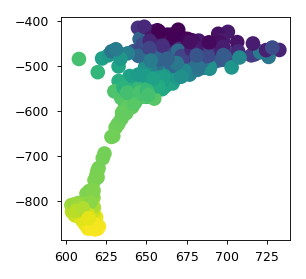

In [18]:
# check that ordering is as expected

coo = pd.read_csv(project_dir+plot_name+'/coordinates.txt',header=None,index_col=0)
x = coo[cmask1][1].values
y = -coo[cmask1][2].values

a,fig,gs=rz.startfig(5,5)
a.scatter(x,y,
          c=vrank,
         )

In [19]:
# cell ordering is store in adata.obs under 'pseudotime_cell_order'
# confirm that the ordering is successfully recreated
np.allclose(vrank,adata[cell_mask].obs['pseudotime_cell_order'].astype(int).values)

True

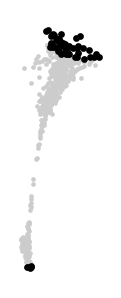

In [20]:
# plot source and sink:
a,fig,gs=rz.startfig(2,5,frameon=False)
a.scatter(x,y,
          c='0.8',   
          s = 5,
          lw=0,
         )

a.set_xticks([])
a.set_yticks([])
blackmask = R!=0
a.scatter(x[blackmask],y[blackmask],
          c='0',   
          s = 5,
         )

gs.tight_layout(fig)

# Order cells, get moving average

In [21]:
def get_error(v,zeros_special=True):
    
    """
    for values in v, get the mean-sem and mean+sem,
    if zeros_special is True, will replace sem with 1/window size if mean == 0
    
    Error are truncated below zero
    """

    themean = np.mean(v)
    if themean == 0.:
        return [0.,1./len(v)]
    else:
        
        er = scipy.stats.sem(v)
        interv = [themean-er,themean+er]
        
        if interv[0]<0:
            interv[0]=0
        return interv

    

def moving_average(ocounts,m,get_conf_int=False):
    
    """
    ocounts - ordered counts pandas dataframe, cells are columns. Original size is (h,w)
    m - window size
    returns a pandas dataframe of size (w,w-m+1)
    """
    
    res = []
    (h,w) = ocounts.shape
    
    
    for i_start in range(w-m+1):
        if i_start/1000. == int(i_start/1000):
            print(i_start)
        i_end = i_start+m
        chunk = ocounts.iloc[:,i_start:i_end]
        if get_conf_int==True:
            res.append(chunk.apply(lambda x:get_error(x),axis=1))
        else:
            res.append(chunk.mean(axis=1))
    return pd.DataFrame(res).T

# Get a dataframe of counts ordered by potential

In [22]:
# select counts, filter on expression level
cmask = adata.obs['population'].isin(toselect).values
E = adata[cmask].X

# place into a pandas dataframe (make dense on the way)
order = np.argsort(vrank)
ocounts = pd.DataFrame(E.toarray()[order,:],columns = adata.var_names)

In [23]:
ocounts.head()

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,...,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,3.397893,0.0,...,10.193680,132.517838,81.549438,33.978935,3.397893,0.0,23.785254,3.397893,6.795787,0.0
1,0.000000,2.772387,0.0,0.0,0.0,0.0,2.772387,0.0,0.000000,0.0,...,11.089548,66.537292,49.902966,30.496258,0.000000,0.0,8.317162,2.772387,0.000000,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,23.696684,94.786736,35.545025,17.772512,5.924171,0.0,29.620855,2.962085,0.000000,0.0
3,5.485464,0.000000,0.0,0.0,0.0,0.0,5.485464,0.0,5.485464,0.0,...,16.456390,65.825562,38.398247,16.456390,5.485464,0.0,16.456390,0.000000,0.000000,0.0
4,7.530120,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,3.765060,0.0,...,18.825300,86.596382,60.240963,18.825300,7.530120,0.0,26.355421,0.000000,3.765060,0.0


In [25]:
def plot_pseudo(
            genes,
            ocounts,
            title=None,
            ci=None,
            m = 10,
            w = 7,
            h = 2.5,
            save=False,
            ylabel='Gene expression',
            xlabel = 'Ameloblast trajectory',
            return_ax = False
            ):
    
    """
    Plots expression of selected genes along the trajectory.
    If return_ax is True, returns a,fig,gs objects (Axes,Figure,GridSpec).
    
    Parameters:
    genes - list of genes to plot
    ocounts - pd.DataFrame containing counts with cells ordered as desired (cells x genes)
    m - windows size for calculating moving average
    
    """

    #plot some genes for demonstration:
    a,fig,gs = rz.startfig(w=w,h=h,columns=2)

    
    #prepare colors
    lab = np.arange(len(genes))
    lab = lab/float(lab.max())
    lab_cmap = plt.cm.get_cmap('jet')
    cs = [lab_cmap(i) for i in lab]
    
    # counts smoothed using a moving average
    mocounts = moving_average(ocounts.loc[genes],m=m)
    
    #confidence intervals:
    if type(ci)==type(None):
        ci = moving_average(ocounts.loc[genes],m=m,get_conf_int=True)
        
    
    for i in range(len(genes)):
        gene = genes[i]
        conf = ci.loc[gene]
        low = conf.apply(lambda x:x[0])
        hi = conf.apply(lambda x:x[1])
        y = mocounts.loc[gene]
        #normalize:
        new=[]
        for z in [y,hi,low]:
            #z = z-z.min()
            z = z/max(y)*100
            new.append(z)
        [y,hi,low]=new
        x = range(mocounts.shape[1])
        aplot = a.plot(x,y,color=cs[i],lw=.5)
        a.fill_between(x,low,hi,lw=0,color=cs[i],alpha=0.3)

    rz.showspines(a,bottom=True,left=True)
    a.set_xlim(0,mocounts.shape[1])
    a.set_yticks([0,100])
    a.set_ylim([0,120])
    #legend
    plt.legend(fontsize=6,
               bbox_to_anchor=(1.55, 1.1),
               labelspacing=0)

    a.set_yticklabels(['0','max'])
    a.set_xticks([])
    a.set_ylabel(ylabel)
    a.set_xlabel(xlabel)
    gene_string = '_'.join(genes)
    if title!=None:
        a.set_title(title,fontsize=7)
        gene_string = gene_string+'_'+title
    
    if return_ax:
        return a,fig,gs
        
    
    
    gs.tight_layout(fig)   
    if save:
        plt.savefig('outputs/trajectory_%s.pdf'%(gene_string))
        
    plt.show()

In [30]:
# get moving average:
# window size to average over
m = 20
mocounts = moving_average(ocounts.T,m=m).T

0


0
0


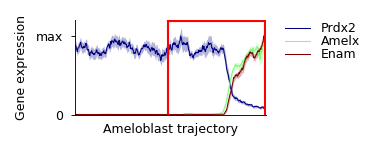

In [31]:
a,fig,gs = plot_pseudo(['Prdx2','Amelx','Enam',
                       ],
           ocounts=ocounts.T,
           w=10,
           m=m,
           return_ax=True,
           )

ts = 200
a.plot((ts,ts),(0.,a.get_ylim()[1]),lw=1,color='r')
a.plot((ts,a.get_xlim()[1]),(a.get_ylim()[1],a.get_ylim()[1]),color='r')
a.plot((a.get_xlim()[1]-1,a.get_xlim()[1]-1),(0.,a.get_ylim()[1]),lw=1,color='r')
gs.tight_layout(fig)

plt.show()